# Детектор лиц
## RetinaFace: Single-shot Multi-level Face Localisation in the Wild 
![FRS](imgs/retinaface.png "FRS")

Реализация сетки взята из репозитория https://github.com/peteryuX/retinaface-tf2. Данная архитектура немного отходит от оригинальной бумаги и оптимизирует __3 компонентный loss__, вместо __4 компонентного__ как оригинальной статье - https://arxiv.org/pdf/1905.00641.pdf. Но так как мы обучаемся на датасете __Wider Faces__, то попиксельная регрессия лица для построения 3D сетки нам не нужна.

![](imgs/loss.png)

Рассматриваемая ахритектура является так называем Single-shot детектором или One-stage, когда за 1 проход сети в случае __RetinaFace__ мы получаем координаты баундинг бокса, метку класса и 5 точек лица.

In [1]:
import os
import zipfile
from dataclasses import dataclass

from absl import logging
import tqdm
import random
import tensorflow as tf
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model

import copy

import numpy as np

%matplotlib inline

In [2]:
# Определим пути нашего приложения в контейнере
APP_DIR = '/app/'
DATA_DIR = APP_DIR + 'data/'
DATASET_DIR = DATA_DIR + 'widerface' + '/'

# Путь к конфигурации обучения
CFG_PATH = f'{APP_DIR}configs/retinaface_res50.yaml' # retinaface_mbv2.yaml

import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
                
def dataset_loader(gdrive_file_id=None, dataset_path=None, ds_type='train'):
    assert ds_type in ['train', 'val', 'annotations'], 'Датасет может быть test, val, annotations'
    assert gdrive_file_id is not None, 'Укажите ID файла GDrive'
    assert dataset_path is not None, 'Укажите путь к папке в которую сохранить датасет'
    
    destination = dataset_path + f'{ds_type}.zip'

    if not os.path.exists(destination):
        print(f'Загружаем {ds_type}.zip...')
        download_file_from_google_drive(gdrive_file_id, destination)
        
def extract_dataset(dataset_path, dataset_type):
    destination = dataset_path + f'{dataset_type}.zip'
    if not os.path.exists(dataset_path):
        zip_ref = zipfile.ZipFile(destination, 'r')
        zip_ref.extractall(dataset_path)
        zip_ref.close()
        print('Загрузка завершена!\n')
        
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size

    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [3]:
# Загрузим наш датасет
# Так как с официальных ссылок Wider Face автоматически скачать не получается я перезалил их в облако
dataset_ids = {
    'train': '1sc3lUr_7LppHPEC5FhXiTIxn1HuhZNoo',
    'val': '1YW2_XQ1l30usbKkWCSrmf4oIC9AHRyga',
    'annotations': '1vgCABX1JI3NGBzsHxwBXlmRjaLV3NIsG'
}

!mkdir -p {DATASET_DIR}train
!mkdir -p {DATASET_DIR}val

for dataset_type in ['train', 'val', 'annotations']:
    dataset_loader(dataset_ids[dataset_type], DATASET_DIR, dataset_type)
    extract_dataset(DATASET_DIR, dataset_type)    

In [4]:
# Посмотрим на загруженные данные
!ls -la {DATASET_DIR}

total 1789928
drwxr-xr-x 5 root root       4096 Sep 26 15:18 .
drwxr-xr-x 3 1000 1000       4096 Sep 26 15:22 ..
-rw-r--r-- 1 root root    4494280 Sep 26 15:16 annotations.zip
drwxr-xr-x 2 root root       4096 Sep 26 15:16 test
drwxr-xr-x 3 root root       4096 Sep 26 15:16 train
-rw-r--r-- 1 root root 1465602149 Sep 26 15:15 train.zip
drwxr-xr-x 3 root root       4096 Sep 26 15:16 val
-rw-r--r-- 1 root root  362752168 Sep 26 15:15 val.zip


In [5]:
# Приведем к нормальному виду структуру папок
!mv {DATASET_DIR}WIDER_train/images {DATASET_DIR}train/images
!rm -R {DATASET_DIR}WIDER_train
!mv {DATASET_DIR}WIDER_val/images {DATASET_DIR}val/images
!rm -R {DATASET_DIR}WIDER_val

mv: cannot stat '/app/data/widerface/WIDER_train/images': No such file or directory
rm: cannot remove '/app/data/widerface/WIDER_train': No such file or directory
mv: cannot stat '/app/data/widerface/WIDER_val/images': No such file or directory
rm: cannot remove '/app/data/widerface/WIDER_val': No such file or directory


## Подгтовка датасета
### Для того, чтобы обучить TF модель необходимо преобразовать наши данные в форма TFRecord


In [6]:
@dataclass
class TFRecordWider:
    
    dataset_path: str = './data/widerface/'
    out_file_name: str = './data/widerface_train_bin.tfrecord'
    
    @staticmethod
    def _bytes_feature(value):
        """Returns a bytes_list from a string / byte."""
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

    @staticmethod
    def _float_feature(value):
        """Returns a float_list from a float / double."""
        return tf.train.Feature(float_list=tf.train.FloatList(value=value))

    @staticmethod
    def _int64_feature(value):
        """Returns an int64_list from a bool / enum / int / uint."""
        return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

    def make_example(self, img_name, img_path, target):
        # Create a dictionary with features that may be relevant.
        feature = {'image/img_name': self._bytes_feature([img_name]),
                   'image/object/bbox/xmin': self._float_feature(target[:, 0]),
                   'image/object/bbox/ymin': self._float_feature(target[:, 1]),
                   'image/object/bbox/xmax': self._float_feature(target[:, 2]),
                   'image/object/bbox/ymax': self._float_feature(target[:, 3]),
                   'image/object/landmark0/x': self._float_feature(target[:, 4]),
                   'image/object/landmark0/y': self._float_feature(target[:, 5]),
                   'image/object/landmark1/x': self._float_feature(target[:, 6]),
                   'image/object/landmark1/y': self._float_feature(target[:, 7]),
                   'image/object/landmark2/x': self._float_feature(target[:, 8]),
                   'image/object/landmark2/y': self._float_feature(target[:, 9]),
                   'image/object/landmark3/x': self._float_feature(target[:, 10]),
                   'image/object/landmark3/y': self._float_feature(target[:, 11]),
                   'image/object/landmark4/x': self._float_feature(target[:, 12]),
                   'image/object/landmark4/y': self._float_feature(target[:, 13]),
                   'image/object/landmark/valid': self._float_feature(target[:, 14])}
            
        # Binary Image
        img_str = open(img_path, 'rb').read()
        feature['image/encoded'] = self._bytes_feature([img_str])

        return tf.train.Example(features=tf.train.Features(feature=feature))

    @staticmethod
    def load_info(txt_path):
        """load info from txt"""
        img_paths = []
        words = []

        f = open(txt_path, 'r')
        lines = f.readlines()
        isFirst = True
        labels = []
        for line in lines:
            line = line.rstrip()
            if line.startswith('#'):
                if isFirst is True:
                    isFirst = False
                else:
                    labels_copy = labels.copy()
                    words.append(labels_copy)
                    labels.clear()
                path = line[2:]
                path = txt_path.replace('label.txt', 'images/') + path
                img_paths.append(path)
            else:
                line = line.split(' ')
                label = [float(x) for x in line]
                labels.append(label)

        words.append(labels)
        return img_paths, words

    @staticmethod
    def get_target(labels):
        annotations = np.zeros((0, 15))
        if len(labels) == 0:
            return annotations
        for idx, label in enumerate(labels):
            annotation = np.zeros((1, 15))
            # bbox
            annotation[0, 0] = label[0]  # x1
            annotation[0, 1] = label[1]  # y1
            annotation[0, 2] = label[0] + label[2]  # x2
            annotation[0, 3] = label[1] + label[3]  # y2

            # landmarks
            annotation[0, 4] = label[4]    # l0_x
            annotation[0, 5] = label[5]    # l0_y
            annotation[0, 6] = label[7]    # l1_x
            annotation[0, 7] = label[8]    # l1_y
            annotation[0, 8] = label[10]   # l2_x
            annotation[0, 9] = label[11]   # l2_y
            annotation[0, 10] = label[13]  # l3_x
            annotation[0, 11] = label[14]  # l3_y
            annotation[0, 12] = label[16]  # l4_x
            annotation[0, 13] = label[17]  # l4_y
            if (annotation[0, 4] < 0):
                annotation[0, 14] = -1  # w/o landmark
            else:
                annotation[0, 14] = 1

            annotations = np.append(annotations, annotation, axis=0)
        target = np.array(annotations)

        return target


    def transform(self):
        if not os.path.isdir(self.dataset_path):
            logging.info('Please define valid dataset path.')
        else:
            logging.info('Loading {}'.format(self.dataset_path))

        logging.info('Reading data list...')
        img_paths, words = self.load_info(os.path.join(self.dataset_path, 'label.txt'))
        samples = list(zip(img_paths, words))
        random.shuffle(samples)

        if os.path.exists(self.out_file_name):
            logging.info('{:s} already exists. Exit...'.format(
                self.out_file_name))
            exit()

        logging.info('Writing {} sample to tfrecord file...'.format(len(samples)))
        
        with tf.io.TFRecordWriter(self.out_file_name) as writer:
            for img_path, word in tqdm.tqdm(samples):
                target = self.get_target(word)
                img_name = os.path.basename(img_path).replace('.jpg', '')

                tf_example = self.make_example(img_name=str.encode(img_name),
                                          img_path=str.encode(img_path),
                                          target=target)

                writer.write(tf_example.SerializeToString())

In [7]:
# Подготовим TFRecord
# train_path = os.path.join(DATASET_DIR, 'train')
# train_tf_record = os.path.join(DATA_DIR, 'widerface_train_bin.tfrecord')
# tfds = TFRecordWider(train_path, train_tf_record)
# tfds.transform()

In [8]:
# Зададим настройки обучения модели
BATCH_SIZE = 4 # при большем размере GTX 1060 уходит в OOM
EPOCHS = 100

## Настройки конфигов обученияr
MODELS_CONFIG = {
    'ResNet50': {
        'cfg_path': f'{APP_DIR}configs/retinaface_res50.yaml',
        'dataset_path': f'{APP_DIR}data/widerface_train_bin.tfrecord',
        'batch_size': BATCH_SIZE,
        'testing_dataset_path': f'{APP_DIR}data/widerface/val',
        'epoch': EPOCHS
    },
    'MobileNetV2': {
        'cfg_path': f'{APP_DIR}configs/retinaface_mbv2.yaml',
        'dataset_path': f'{APP_DIR}data/widerface_train_bin.tfrecord',
        'batch_size': BATCH_SIZE,
        'testing_dataset_path': f'{APP_DIR}data/widerface/val',
        'epoch': EPOCHS
    }
}

# Выберем backbone для RetinaFace
backbone_model = 'ResNet50'

dataset_path = MODELS_CONFIG[backbone_model]['dataset_path']
cfg_path = MODELS_CONFIG[backbone_model]['cfg_path']
batch_size = MODELS_CONFIG[backbone_model]['batch_size'] 
testing_dataset_path = MODELS_CONFIG[backbone_model]['testing_dataset_path']
epoch = MODELS_CONFIG[backbone_model]['epoch']

custom_config_path = f'{APP_DIR}configs/my_train_cfg.yaml'

In [9]:
# Внесем в конфиг некоторые изменения
import re

print('Вносим изменения в конфигурационный файл...')

with open(cfg_path) as f:
    s = f.read()
with open(custom_config_path, 'w') as f:

    # Batch_size
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Epochs
    epoch_re = re.compile(r"^epoch: [0-9]+", re.MULTILINE)
    s = re.sub(epoch_re,
               'epoch: {}'.format(epoch), s)
    
    # Dataset path
    s = re.sub('dataset_path: \'.\/data\/widerface_train_bin.tfrecord\'', f"dataset_path: '{dataset_path}'", s)
    
    # Val path
    s = re.sub('testing_dataset_path: \'.\/data\/widerface\/val\'', f"testing_dataset_path: '{testing_dataset_path}'", s)
            
    f.write(s)
    
print(f'Создан новый конфигурационный файл {custom_config_path}')

Вносим изменения в конфигурационный файл...
Создан новый конфигурационный файл /app/configs/my_train_cfg.yaml


In [10]:
!cat {custom_config_path}

# general setting
batch_size: 4
input_size: 640
backbone_type: 'ResNet50'  # 'ResNet50', 'MobileNetV2'
sub_name: 'retinaface_res50'

# training dataset
dataset_path: '/app/data/widerface_train_bin.tfrecord'
dataset_len: 12880  # number of training samples
using_bin: True
using_flip: True
using_distort: True

# testing dataset
testing_dataset_path: '/app/data/widerface/val'

# network
out_channel: 256

# anchor setting
min_sizes: [[16, 32], [64, 128], [256, 512]]
steps: [8, 16, 32]
match_thresh: 0.45
ignore_thresh: 0.3
variances: [0.1, 0.2]
clip: False

# training setting
epoch: 100
init_lr: !!float 1e-2
lr_decay_epoch: [50, 68]
lr_rate: 0.1
warmup_epoch: 5
min_lr: !!float 1e-3

weights_decay: !!float 5e-4
momentum: 0.9

pretrain: True

save_steps: 2000


## Обучаем модель

In [11]:
# Импортируем необходимые модули
from modules.models import RetinaFaceModel
from modules.lr_scheduler import MultiStepWarmUpLR
from modules.losses import MultiBoxLoss
from modules.anchor import prior_box
from modules.utils import (set_memory_growth, load_yaml, load_dataset,
                           ProgressBar, draw_bbox_landm, pad_input_image, recover_pad_output)

from modules.face import FaceAligner

In [12]:
# Наша модель
class RetinaFace:
    
    # Загрузка чекпойнта
    def __load_checkpoint(self):

        checkpoint_dir = './checkpoints/' + self.cfg['sub_name']
        checkpoint = tf.train.Checkpoint(step=tf.Variable(0, name='step'),
                                         optimizer=self.optimizer,
                                         model=self.model)
        manager = tf.train.CheckpointManager(checkpoint=checkpoint,
                                             directory=checkpoint_dir,
                                             max_to_keep=3)
        if manager.latest_checkpoint:
            checkpoint.restore(manager.latest_checkpoint)
            print('[*] load ckpt from {} at step {} for training.'.format(
                manager.latest_checkpoint, checkpoint.step.numpy()))
        else:
            print("[*] training from scratch.")
            
        return manager, checkpoint
    
    
    def get_model(self):
        return self.model
        
    
    def __init__(self, cfg, **kwargs):
        # init
        SCORE_TH = 0.5
        IOU_TH = 0.4
        
        self.manager = None
        self.checkpoint = None
        
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
        os.environ['CUDA_VISIBLE_DEVICES'] = '0'

        logger = tf.get_logger()
        logger.disabled = True
        logger.setLevel(logging.FATAL)
        set_memory_growth()
        
        # Конфиг
        self.cfg = load_yaml(cfg)
        
        # Наша модель
        self.model = RetinaFaceModel(self.cfg, training=True)
        self.predict_model = RetinaFaceModel(self.cfg, training=False, iou_th=IOU_TH,
                            score_th=SCORE_TH)
        
        self.priors = prior_box((self.cfg['input_size'], self.cfg['input_size']),
                           self.cfg['min_sizes'],  self.cfg['steps'], self.cfg['clip'])
        
        # Датасет
        self.train_dataset = load_dataset(self.cfg, self.priors, shuffle=True)
        
        # Шаг
        self.steps_per_epoch = self.cfg['dataset_len'] // self.cfg['batch_size']
        
        # LR
        self.learning_rate = MultiStepWarmUpLR(
            initial_learning_rate=self.cfg['init_lr'],
            lr_steps=[e * self.steps_per_epoch for e in self.cfg['lr_decay_epoch']],
            lr_rate=self.cfg['lr_rate'],
            warmup_steps=self.cfg['warmup_epoch'] * self.steps_per_epoch,
            min_lr=self.cfg['min_lr'])
        
        # Otpimizer (SGD как в бумаге)
        self.optimizer = tf.keras.optimizers.SGD(
            learning_rate=self.learning_rate, momentum=0.9, nesterov=True)
        
        # Loss
        self.multi_box_loss = MultiBoxLoss()
        
        # Fit Status
        self.is_fitted = False
        
    
    # Обучаем модель
    def fit(self):
        # Чекпойнты
        self.manager, self.checkpoint = self.__load_checkpoint()    
        
        # Шаг обучения
        @tf.function
        def train_step(inputs, labels):
            with tf.GradientTape() as tape:
                predictions = self.model(inputs, training=True)

                losses = {}
                losses['reg'] = tf.reduce_sum(self.model.losses)
                losses['loc'], losses['landm'], losses['class'] = \
                    self.multi_box_loss(labels, predictions)
                total_loss = tf.add_n([l for l in losses.values()])

            grads = tape.gradient(total_loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

            return total_loss, losses

        # Цикл обучения модели
        summary_writer = tf.summary.create_file_writer('./logs/' + self.cfg['sub_name'])
        remain_steps = max(
            self.steps_per_epoch * self.cfg['epoch'] - self.checkpoint.step.numpy(), 0)
        prog_bar = ProgressBar(self.steps_per_epoch,
                               self.checkpoint.step.numpy() % self.steps_per_epoch)
        
        if remain_steps > 0:
            for inputs, labels in self.train_dataset.take(remain_steps):
                self.checkpoint.step.assign_add(1)
                steps = self.checkpoint.step.numpy()

                total_loss, losses = train_step(inputs, labels)

                prog_bar.update("epoch={}/{}, loss={:.4f}, lr={:.1e}".format(
                    ((steps - 1) // self.steps_per_epoch) + 1, self.cfg['epoch'],
                    total_loss.numpy(), self.optimizer.lr(steps).numpy()))

                if steps % 10 == 0:
                    with summary_writer.as_default():
                        tf.summary.scalar(
                            'loss/total_loss', total_loss, step=steps)
                        for k, l in losses.items():
                            tf.summary.scalar('loss/{}'.format(k), l, step=steps)
                        tf.summary.scalar(
                            'learning_rate', self.optimizer.lr(steps), step=steps)

                if steps % self.cfg['save_steps'] == 0:
                    self.manager.save()
                    print("\n[*] save ckpt file at {}".format(
                        self.manager.latest_checkpoint))

            self.manager.save()
            print("\n[*] training done! save ckpt file at {}".format(
                self.manager.latest_checkpoint))
        
        self.is_fitted = True
    
    
    '''Принимает список изображений'''
    def predict(self, X):
        down_scale_factor = 1
        
        assert self.is_fitted == True, "Сначала обучите модель методом fit"
        assert isinstance(X, list), "Передайте список изображений numpy"
        
        # Inference model checkpoint
        checkpoint_dir = './checkpoints/' + self.cfg['sub_name']
        checkpoint = tf.train.Checkpoint(model=self.predict_model)
        
        if tf.train.latest_checkpoint(checkpoint_dir):
            checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
            print("[*] load ckpt from {} to inference model.".format(
                tf.train.latest_checkpoint(checkpoint_dir)))
        else:
            print("[*] Cannot find ckpt from {}.".format(checkpoint_dir))
            exit()
        
        predicts = {}
        
        predicts['outputs'] = []
        predicts['image_params'] = []
        
        for _img in X:
            
            img_raw = cv2.imread(_img)
            img_height_raw, img_width_raw, _ = img_raw.shape
            img = np.float32(img_raw.copy())

            if down_scale_factor < 1.0:
                img = cv2.resize(img, (0, 0), fx=down_scale_factor,
                                 fy=down_scale_factor,
                                 interpolation=cv2.INTER_LINEAR)
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # pad input image to avoid unmatched shape problem
            img, pad_params = pad_input_image(img, max_steps=max(self.cfg['steps']))

            # run model
            outputs = self.predict_model(img[np.newaxis, ...]).numpy()

            # recover padding effect
            outputs = recover_pad_output(outputs, pad_params)
            
            predicts['outputs'].append(outputs)
            predicts['image_params'].append((img_width_raw, img_height_raw))
        
        
        return predicts

In [13]:
# Создадим модель
model = RetinaFace(cfg_path)
model.get_model().summary()


Model: "RetinaFaceModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 640, 640, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
tf.nn.bias_add (TFOpLambda)     (None, 640, 640, 3)  0           tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________________
ResNet50_extrator (Functional)  ((None, 80, 80, 512) 23587712    tf.nn.bias_add[0][0]             
____________________________________________________________________________________

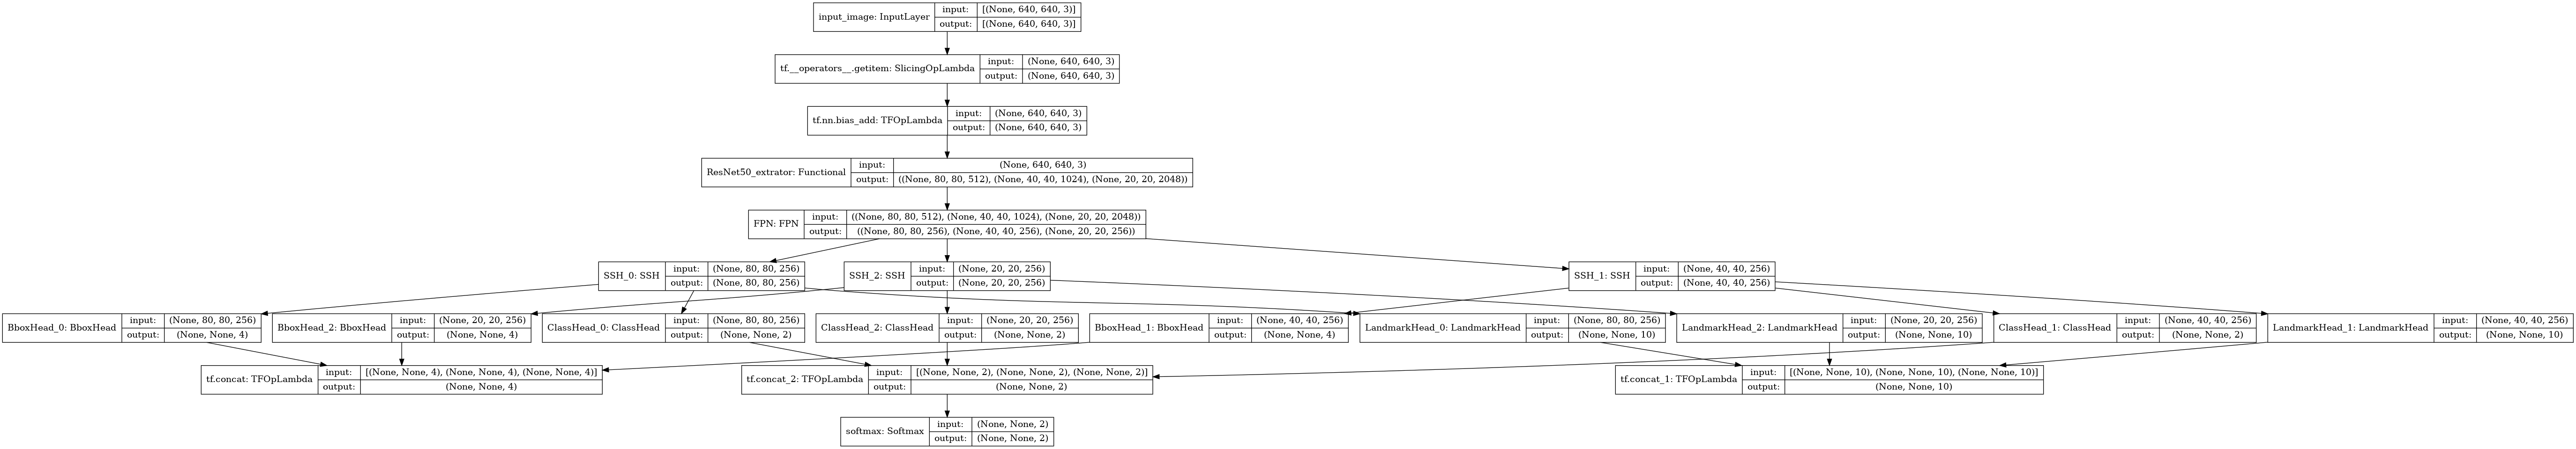

In [14]:
# Посмотрим визуализацию
plot_model(model.get_model(), show_shapes=True, show_layer_names=True)

In [15]:
# Обучим нашу модель или загрузим последний чекпойнт
model.fit()

[*] load ckpt from ./checkpoints/retinaface_res50/ckpt-81 at step 161000 for training.


In [45]:
# Протестируем нашу модель на валидационной выборке
test_images = []

for path, subdirs, files in os.walk(DATASET_DIR + '/val'):
    for name in files:
        if name.endswith('.jpg'):
            test_images.append(os.path.join(path, name))


y_pred = model.predict(test_images[:10])

[*] load ckpt from ./checkpoints/retinaface_res50/ckpt-81 to inference model.


In [46]:
# Функция рисования баундинг бокса и лэндмарков
def draw_bbox_and_landmarks(raw_image_list, predictions):
    
    preds_imgs = []
    
    for idx, pred in enumerate(predictions):
        img_raw = cv2.imread(raw_image_list[idx])
        img_height_raw, img_width_raw, _ = img_raw.shape
               
        for prior_index in range(len(pred)):
            draw_bbox_landm(img_raw, pred[prior_index], img_height_raw,
                            img_width_raw)
            
        preds_imgs.append(img_raw)
        
    return preds_imgs


def decode_predictions(image_params, y_pred_outputs):
    
    face_dict = {}

    for pred_index in range(len(y_pred_outputs)):
        img_width, img_height = image_params[0], image_params[1]
        ann = y_pred_outputs[pred_index]

        # bbox
        x1, y1, x2, y2 = int(ann[0] * img_width), int(ann[1] * img_height), \
                         int(ann[2] * img_width), int(ann[3] * img_height)

        # confidence
        conf = "{:.4f}".format(ann[15])

        # landmark
        if ann[14] > 0:
            right_eye = (int(ann[4] * img_width), int(ann[5] * img_height))
            left_eye = (int(ann[6] * img_width), int(ann[7] * img_height))
            nose = (int(ann[8] * img_width), int(ann[9] * img_height))
            mouth_right = (int(ann[10] * img_width), int(ann[11] * img_height))
            mouth_left = (int(ann[12] * img_width),int(ann[13] * img_height))           

        current_face = {'bbox': [x1, y1, x2, y2], 'score':conf, 'right_eye': right_eye, \
                        'left_eye': left_eye, 'nose': nose, 'mouth_right': mouth_right, \
                        'mouth_left': mouth_left}

        face_dict.setdefault(f'face_{pred_index}', []).append(current_face)

    return face_dict

# Нарисуем баундбоксы
boxed_img = draw_bbox_and_landmarks(test_images, y_pred['outputs'])

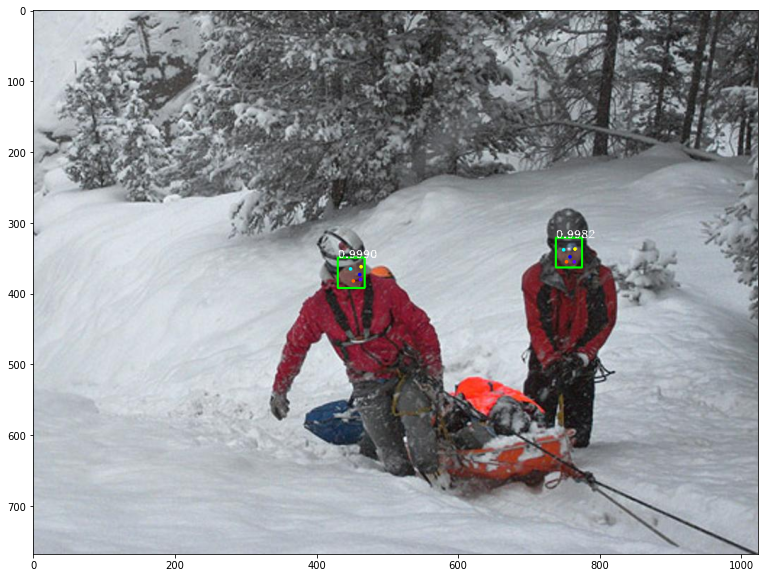

In [56]:
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(boxed_img[4], cv2.COLOR_BGR2RGB))

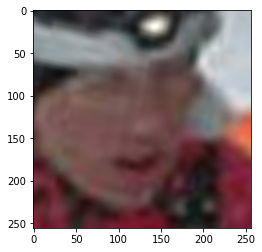

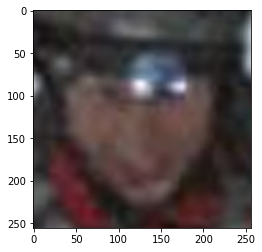

In [57]:
img_id = 4
# Протестируем выравнивание лица
test_img4 = y_pred['image_params'][img_id]
test_img4_preds = y_pred['outputs'][img_id]

decoded_preds = decode_predictions(test_img4, test_img4_preds)

face_aligner = FaceAligner()


for _, value in decoded_preds.items():
    _img = cv2.imread(test_images[img_id])
    _img = face_aligner.align(_img, value[0]["left_eye"], value[0]["right_eye"])
    plt.figure()
    plt.imshow(cv2.cvtColor(_img, cv2.COLOR_BGR2RGB))    


# Тестируем модель

In [20]:
# Сформируем предсказания для проверки точности на валидационном датасете
#!python {APP_DIR}test_widerface.py --cfg_path="/app/retinaface/configs/my_train_cfg.yaml" --gpu=0

In [21]:
# Запустим скрипт проверки точности наших предсказаний
#!python {APP_DIR}widerface_evaluate/evaluation.py -p /app/widerface_evaluate/widerface_txt -g /app/retinaface/widerface_evaluate/ground_truth/

Мы получили достаточно неплохой результат для обучения при batch=4 на __GTX1060 6Gb RAM__. Оригинальную модель обучали на четырех NVIDIA Tesla P40 (24GB) GPUs с __batch_size=8x4__ в течении 80 эпох и результат на __Hard__ получили __0.914__.

__Easy   Val AP: 0.9326500330889518__

__Medium Val AP: 0.9272330939112695__

__Hard   Val AP: 0.8064947436317331__

![](imgs/retinaface_paper.png)

RetinaFace до сих пор является одним из sota решений в области детектирования лица.